In [10]:
# Data imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib widget

# ML imports
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers.legacy import Adam


# Other imports
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

tf.keras.backend.set_floatx('float64')
tf.autograph.set_verbosity(0)



/Users/veer/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [7]:
df = pd.read_csv('../../data/final/2022.csv').drop(columns=['Unnamed: 0'])
df.head()

,player_id,Player,Nation,Pos,Squad,Comp,Age,Gls,Ast,G+A,G-PK,G+A-PK,xG,xAG,xG+xAG,npxG,npxG+xAG
0,1000,Salis Abdul Samed,GHA,MF,Lens,Ligue 1,22,0.03,0.03,0.06,0.03,0.06,0.03,0.05,0.08,0.03,0.08
1,1001,Francesco Acerbi,ITA,DF,Inter,Serie A,34,0.00,0.07,0.07,0.00,0.07,0.04,0.04,0.08,0.04,0.08
2,1002,Marcos Acuña,ARG,DF,Sevilla,La Liga,30,0.14,0.09,0.24,0.14,0.24,0.05,0.20,0.26,0.05,0.26
3,1003,Karim Adeyemi,GER,"FW,MF",Dortmund,Bundesliga,20,0.39,0.32,0.71,0.39,0.71,0.33,0.24,0.57,0.28,0.52
4,1004,Yacine Adli,FRA,"MF,FW",Milan,Serie A,22,0.00,0.00,0.00,0.00,0.00,0.05,0.16,0.22,0.05,0.22


In [9]:
X = df.drop(columns=['player_id', 'Player', 'Nation', 'Pos', 'Squad', 'Comp', 'Age', 'Gls'])
y = df['Gls']
print(X.shape, y.shape)

(926, 9) (926,)


In [13]:
# Splitting the data, 70% train, 20% cross-validation, 10% test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=1)
X_cv, X_test, y_cv, y_test = train_test_split(X_temp, y_temp, test_size=0.33, random_state=1)
print("X_train.shape:", X_train.shape, "X_cv.shape:", X_cv.shape, "X_test.shape:", X_test.shape)
print("y_train.shape:",y_train.shape, "y_cv.shape:", y_cv.shape, "y_test.shape:", y_test.shape)

X_train.shape: (648, 9) X_cv.shape: (186, 9) X_test.shape: (92, 9)
y_train.shape: (648,) y_cv.shape: (186,) y_test.shape: (92,)


In [14]:
normalizer = tf.keras.layers.Normalization(input_shape=[X_train.shape[1],])
normalizer.adapt(np.array(X_train))
print(normalizer.mean.numpy())

first = np.array(X_train[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

[[0.08092813 0.18529321 0.09652116 0.17762125 0.11477734 0.0770172
  0.19167108 0.10679012 0.18348545]]
First example: [[0. 0. 0. 0. 0. 0. 0. 0. 0.]]

Normalized: [[-0.35 -0.54 -0.52 -0.53 -0.51 -0.73 -0.69 -0.5  -0.69]]


In [15]:
def build_and_compile_model(norm):
    model = Sequential([
        norm,
        Dense(120, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.1), name='L1'),
        Dense(40, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.1), name='L2'),
        Dense(1, activation='linear')
    ])
    model.compile(loss='mean_absolute_error',
                  optimizer=Adam(learning_rate=1e-3))
    return model

In [16]:
# Build and compile the model
dnn_model = build_and_compile_model(normalizer)

# Optionally: define early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    patience=50, # number of epochs to wait for improvement
    min_delta=0.001, # min change to qualify as an improvement
    restore_best_weights=True, # restore model weights from the epoch with the best value of the monitored quantity.
)

# Train the model
history = dnn_model.fit(
    X_train, y_train,
    validation_data=(X_cv, y_cv),
    epochs=1000,
    callbacks=[early_stopping]
)

Epoch 1/1000
21/21 [==============================] - 0s 4ms/step - loss: 6.8709 - val_loss: 5.8261
Epoch 2/1000
21/21 [==============================] - 0s 1ms/step - loss: 5.0359 - val_loss: 4.2199
Epoch 3/1000
21/21 [==============================] - 0s 1ms/step - loss: 3.6449 - val_loss: 3.0379
Epoch 4/1000
21/21 [==============================] - 0s 1ms/step - loss: 2.6122 - val_loss: 2.1623
Epoch 5/1000
21/21 [==============================] - 0s 1ms/step - loss: 1.8573 - val_loss: 1.5283
Epoch 6/1000
21/21 [==============================] - 0s 1ms/step - loss: 1.3092 - val_loss: 1.0743
Epoch 7/1000
21/21 [==============================] - 0s 1ms/step - loss: 0.9188 - val_loss: 0.7520
Epoch 8/1000
21/21 [==============================] - 0s 1ms/step - loss: 0.6401 - val_loss: 0.5198
Epoch 9/1000
21/21 [==============================] - 0s 1ms/step - loss: 0.4444 - val_loss: 0.3665
Epoch 10/1000
21/21 [==============================] - 0s 1ms/step - loss: 0.3116 - val_loss: 0.2548

In [17]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

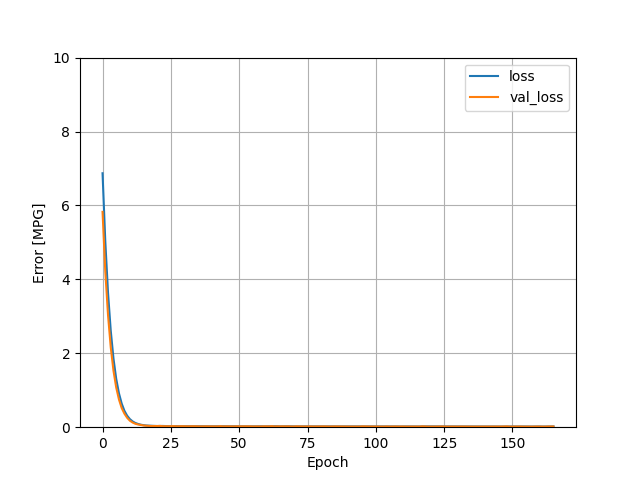

In [18]:
plot_loss(history)

In [19]:
dnn_model.evaluate(X_test, y_test, verbose=0)

0.016358928928615016